In [1]:
!pip -V

pip 23.3.1 from /opt/conda/lib/python3.10/site-packages/pip (python 3.10)


In [2]:
!pip list | grep clip

clip                      1.0


In [3]:
# !pip install git+https://github.com/mhamilton723/FeatUp.git
# !pip install pip install git+https://github.com/openai/CLIP.git

# .init

In [ ]:
%load_ext autoreload
%autoreload 2

In [5]:
import torch
import torchvision.transforms as T
from PIL import Image

from featup.util import norm, unnorm
from featup.plotting import plot_feats, plot_lang_heatmaps

## Dino v2 upsampler

In [6]:
import matplotlib.pyplot as plt
from featup.util import pca, remove_axes
from featup.featurizers.maskclip.clip import tokenize
from pytorch_lightning import seed_everything
import torch
import torch.nn.functional as F

from fmc.plot_utils import plot_feats_pca, display_image_grid



In [7]:
from fmc.segmenter import init_upsampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
upsampler = init_upsampler(device=device)


/opt/conda/lib/python3.10/site-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/mhamilton723/FeatUp/zipball/main" to /root/.cache/torch/hub/main.zip
/opt/conda/lib/python3.10/site-packages/featup/featurizers/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/opt/conda/lib/python3.10/site-packages/featup/featurizers/

## Patch utils

In [4]:
from fmc.patches_utils import extract_patch, extract_patches_numpy, extract_patches_pillow_matrix, extract_patches_pillow


# Image conf

In [5]:
patch_size = 224
overlap = 0
# patch_size = int(256/2)
# overlap = int(26/2)

step = patch_size - overlap
output_overlap = int(256 * overlap / patch_size)

print(f'{patch_size=} {overlap=} {step=} {output_overlap=}')

transform = T.Compose([
    T.Resize(224),
    T.CenterCrop((224, 224)),
    T.ToTensor(),
    norm
])

patch_size=224 overlap=0 step=224 output_overlap=0


In [6]:
from pathlib import Path

Path.cwd()

PosixPath('/root/feature-map-experiments/notebooks')

## Load images

In [ ]:
# image_path = '/root/feature-map-experiments/assets/c16-part1.png'
image_path = '/root/feature-map-experiments/assets/c17-part1.png'
# image_path = '/root/feature-map-experiments/assets/UT_cytopathology_213_239_roi_7333.jpeg'
# image_path = '../assets/DJI_1065.png'

image = Image.open(image_path).convert("RGB")
image

In [8]:
# patches = extract_patches_pillow(image, patch_size=(patch_size, patch_size), step=patch_size-overlap)
# len(patches)

In [11]:
patches_mat = extract_patches_pillow_matrix(image, patch_size=(patch_size, patch_size), step=(step,step))
patches_mat.shape

(5, 8, 224, 224, 3)

# Draw Patches Grid

In [14]:
print(f'{patches_mat.shape[0:2]=}')

patches_mat_shape = patches_mat.shape[0:2]
flat_patches_mat = patches_mat.reshape(-1, *patches_mat.shape[2:])

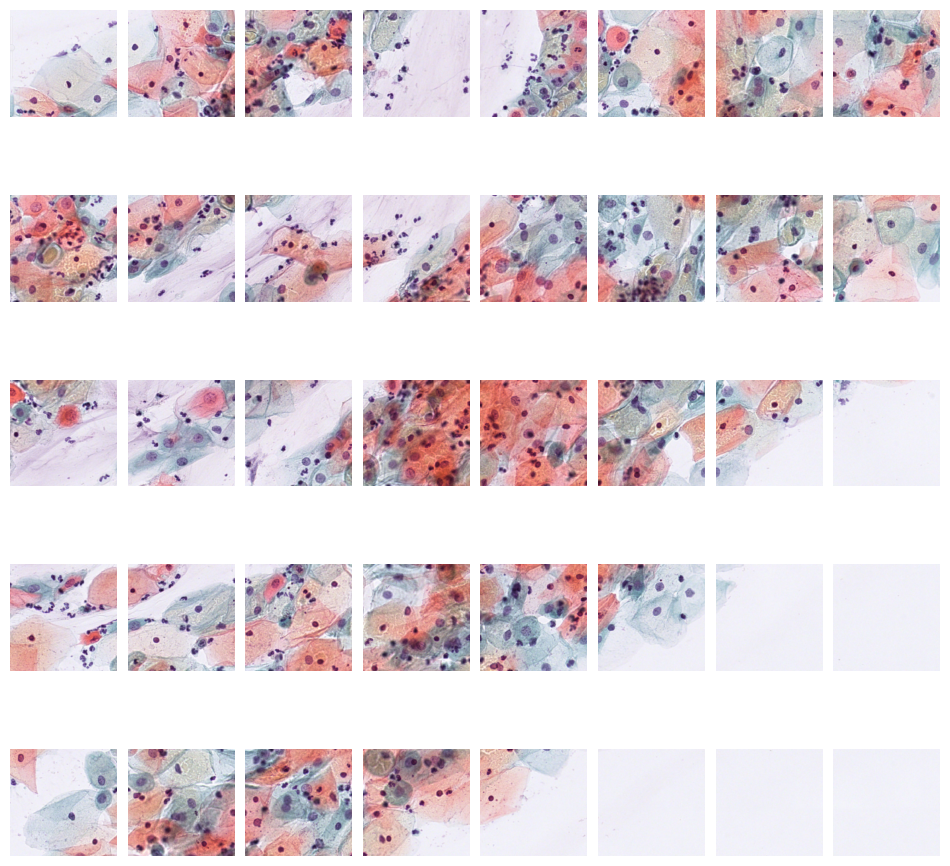

In [15]:
display_image_grid(flat_patches_mat, patches_mat_shape)

# Process using upsampler

## Just pre-experiments

In [16]:
# image_tensor = transform(Image.fromarray(flat_patches_mat[4])).unsqueeze(0).to(device)

In [17]:

# hr_feats = upsampler(image_tensor)
# lr_feats = upsampler.model(image_tensor)
# fit_pca = plot_feats_pca(unnorm(image_tensor)[0], lr_feats[0], hr_feats[0])

In [18]:
# print(f'{hr_feats.shape=} {lr_feats.shape=}')

## Mass processing

In [ ]:
def mass_upsample(upsampler, flat_patches_mat, batch_size=4,):
    image_tensors = [transform(Image.fromarray(p)) for p in flat_patches_mat]
    image_tensors = torch.stack(image_tensors).to(device)
    print(f'{image_tensors.shape=}')

    hr_feats_list = []
    lr_feats_list = []
    num_elements = image_tensors.shape[0]

    for start in range(0, num_elements, batch_size):
        end = min(start + batch_size, num_elements)
        batch = image_tensors[start:end]
        # print(f'{batch.shape=}')

        with torch.no_grad():
            hr_feats_list.append(upsampler(batch).cpu())
            lr_feats_list.append(upsampler.model(batch).cpu())

        torch.cuda.empty_cache()

    lr_feats_list = torch.cat(lr_feats_list, dim=0)
    hr_feats_list = torch.cat(hr_feats_list, dim=0)

    print(f'{lr_feats_list.shape=}  {hr_feats_list.shape=}') 

    return lr_feats_list, hr_feats_list   

In [ ]:
lr_feats_list, hr_feats_list = mass_upsample(upsampler, flat_patches_mat)

In [22]:
# fit_pca = None
# unn_image_tensors = unnorm(image_tensors)
# for i in range(3):
#     fit_pca = plot_feats_pca(unn_image_tensors[i], lr_feats[i], hr_feats[i], fit_pca = fit_pca)

## PCA on image features

Seed set to 0


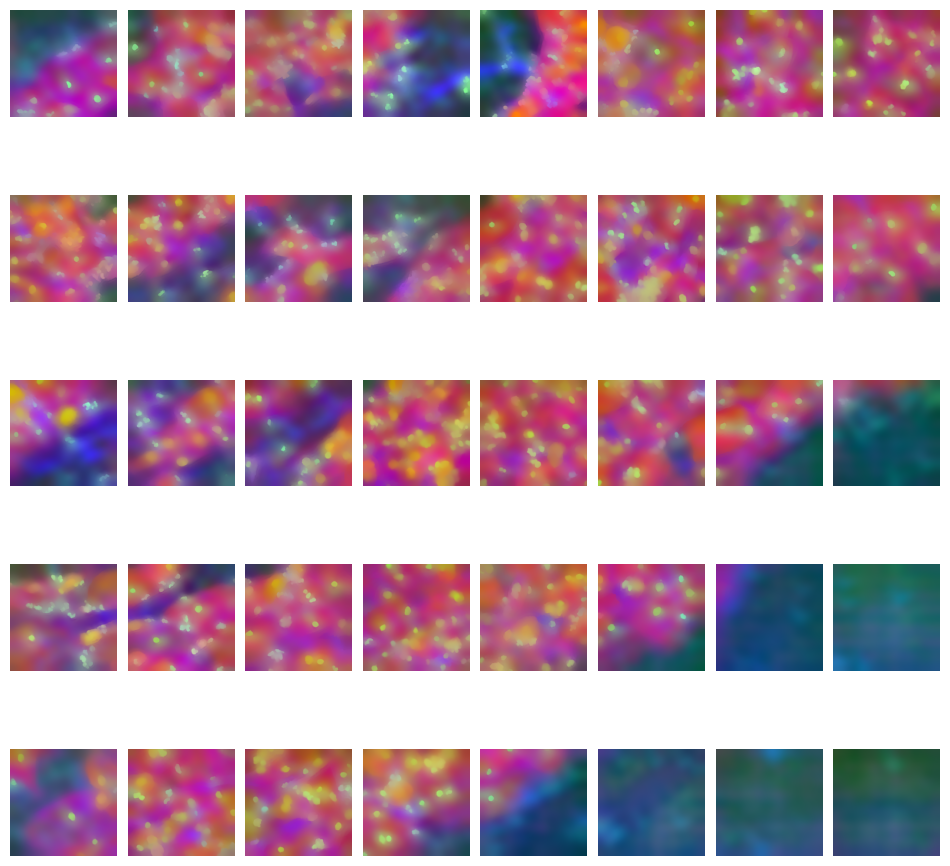

In [23]:
seed_everything(0)
fit_pca = None
use_meaning_center = True
if use_meaning_center:
    _, fit_pca = pca([lr_feats_list[4].unsqueeze(0), hr_feats_list[4].unsqueeze(0)], fit_pca=fit_pca)


[lr_feats_pca, hr_feats_pca], fit_pca = pca([lr_feats_list, hr_feats_list], fit_pca=fit_pca)
# [hr_feats_pca, _], fit_pca = pca([hr_feats_list, hr_feats_list], fit_pca=None)

# ax[2].imshow(hr_feats_pca[0].permute(1, 2, 0).detach().cpu())
hr_feats_pca_arr = [p.permute(1, 2, 0).detach().cpu() for p in hr_feats_pca]

display_image_grid(hr_feats_pca_arr, patches_mat_shape)

In [24]:
len(hr_feats_pca_arr)

40

In [25]:
hr_feats_pca_flat = np.stack(hr_feats_pca_arr)
hr_feats_pca_flat.shape

(40, 256, 256, 3)

In [26]:
hr_feats_mat = hr_feats_pca_flat.reshape(
    patches_mat_shape[0], patches_mat_shape[1], *hr_feats_pca_flat.shape[1:])

hr_feats_mat.shape

(5, 8, 256, 256, 3)

## UMAP on image features

umap fit: x.shape=torch.Size([512, 384])
fit_umap=UMAP(n_components=3, n_jobs=10, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})
umap fit: x.shape=torch.Size([2631680, 384])


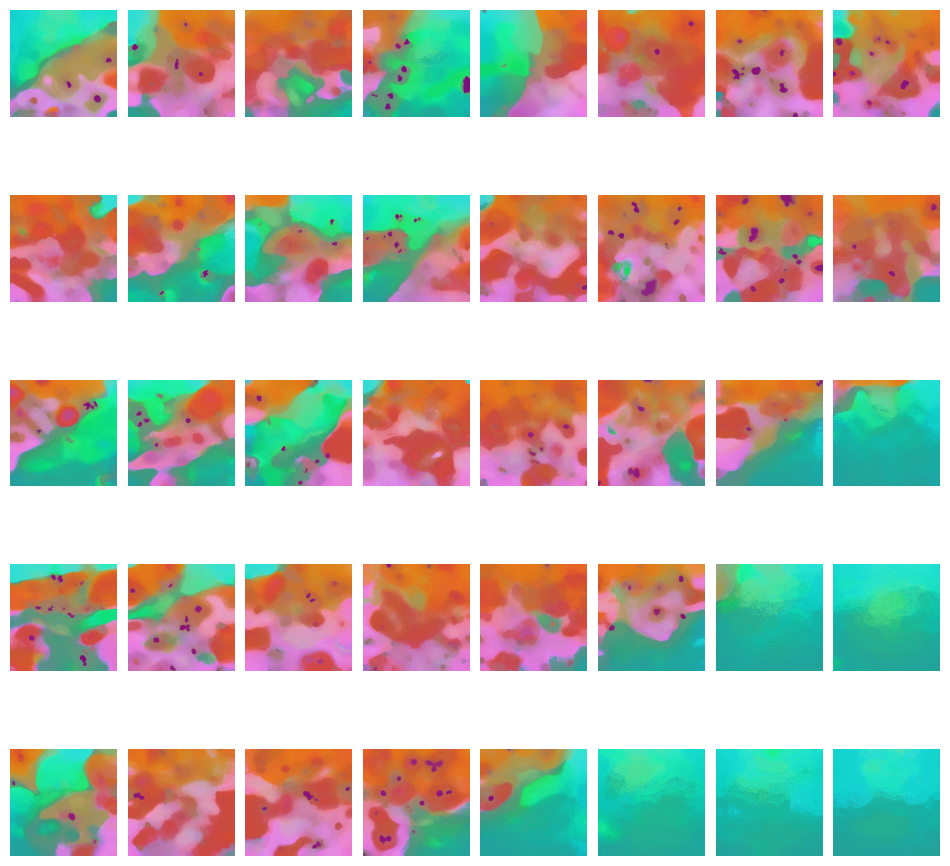

In [28]:
import umap
def umap_fl(image_feats_list, dim=3, fit_umap=None, max_samples=None):
    device = image_feats_list[0].device

    def flatten(tensor, target_size=None):
        if target_size is not None and fit_umap is None:
            tensor = F.interpolate(
                tensor, (target_size, target_size), mode="bilinear")
        B, C, H, W = tensor.shape
        return tensor.permute(1, 0, 2, 3).reshape(C, B * H * W).permute(1, 0).detach().cpu()

    if len(image_feats_list) > 1 and fit_umap is None:
        target_size = image_feats_list[0].shape[2]
    else:
        target_size = None

    flattened_feats = []
    for feats in image_feats_list:
        flattened_feats.append(flatten(feats, target_size))
    x = torch.cat(flattened_feats, dim=0)

    # Subsample the data if max_samples is set and the number of samples exceeds max_samples
    if max_samples is not None and x.shape[0] > max_samples:
        indices = torch.randperm(x.shape[0])[:max_samples]
        x = x[indices]

    print(f'umap fit: {x.shape=}')
    if fit_umap is None:
        fit_umap = umap.UMAP(n_components=dim, 
                            #  random_state=42, 
                             n_jobs=10).fit(x)

    reduced_feats = []
    for feats in image_feats_list:
        x_red = fit_umap.transform(flatten(feats))
        if isinstance(x_red, np.ndarray):
            x_red = torch.from_numpy(x_red)
        x_red -= x_red.min(dim=0, keepdim=True).values
        x_red /= x_red.max(dim=0, keepdim=True).values
        B, C, H, W = feats.shape
        reduced_feats.append(x_red.reshape(
            B, H, W, dim).permute(0, 3, 1, 2).to(device))

    return reduced_feats, fit_umap


fit_umap = None
use_meaning_center = True
if use_meaning_center:
    _, fit_umap = umap_fl([lr_feats_list[4].unsqueeze(0), hr_feats_list[4].unsqueeze(0)], fit_umap=fit_umap)

print(f'{fit_umap=}')
[lr_feats_umap, hr_feats_umap], fit_umap = umap_fl([lr_feats_list, hr_feats_list], fit_umap=fit_umap)
# [hr_feats_pca, _], fit_pca = pca([hr_feats_list, hr_feats_list], fit_pca=None)

# ax[2].imshow(hr_feats_pca[0].permute(1, 2, 0).detach().cpu())
hr_feats_umap_arr = [p.permute(1, 2, 0).detach().cpu() for p in hr_feats_umap]

display_image_grid(hr_feats_umap_arr, patches_mat_shape)

# Clustering features values

## Clustering using pca features

In [30]:
# Combining all 'pixels' into one large dataset

all_feats_values = hr_feats_pca_flat.reshape(-1, 3)
# all_feats_values = hr_feats_list_flat.reshape(-1, 384)
all_feats_values.shape

(2621440, 3)

In [31]:
from sklearn.cluster import KMeans

def kmeans_color_quantization(pixel_values, k=3):
    # Параметры для KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)

    # Применение KMeans
    kmeans.fit(pixel_values)

    # Преобразование центров обратно в uint8
    centers = kmeans.cluster_centers_

    return kmeans, centers


def kmeans_predict(kmeans, hr_feats, palette = None):
    shape = hr_feats.shape
    feats = hr_feats.reshape((-1, shape[-1]))
    # print(f'{shape=} {feats.shape=}')

    labels = kmeans.predict(feats)
    # print(f'{labels.shape=}')
    centers = kmeans.cluster_centers_
    if palette is not None:
        segmented_image = palette[labels.flatten()]
    else:
        segmented_image = centers[labels.flatten()]
    # print(f'{segmented_image.shape=}')
    segmented_image = segmented_image.reshape((shape[0],shape[1],3))
    return segmented_image

In [32]:
# Применение K-means кластеризации ко всему набору данных
k = 10
kmeans, centers = kmeans_color_quantization(all_feats_values, k)

all_segmented_feats = []
for hr_feats in hr_feats_pca_flat:
    segmented_feats = kmeans_predict(kmeans, hr_feats)
    all_segmented_feats.append(segmented_feats)



In [33]:
kmeans.cluster_centers_

array([[0.70026803, 0.32401285, 0.32055408],
       [0.4308154 , 0.2616673 , 0.43357807],
       [0.37420523, 0.2842283 , 0.6231609 ],
       [0.6458574 , 0.22599056, 0.61212337],
       [0.6695259 , 0.6296703 , 0.5316995 ],
       [0.7474494 , 0.5264568 , 0.31513274],
       [0.69360447, 0.24201582, 0.4547592 ],
       [0.18080291, 0.32173678, 0.48125935],
       [0.68551594, 0.40543085, 0.49667966],
       [0.1314201 , 0.3122472 , 0.34377572]], dtype=float32)

## Visualize

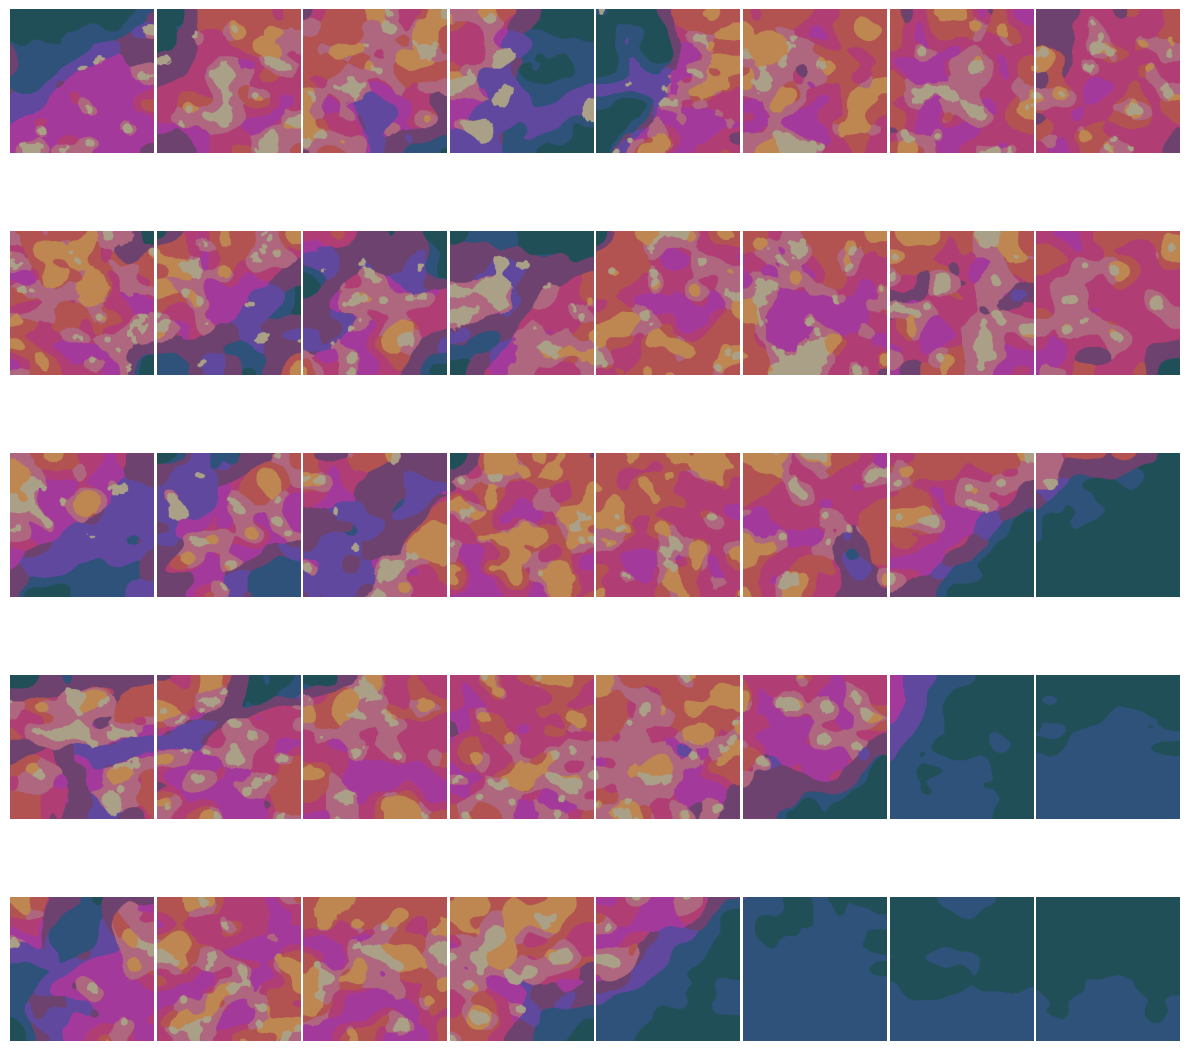

In [34]:
display_image_grid(all_segmented_feats, patches_mat_shape)

## Clustering using original values

In [33]:
hr_feats_list.shape

torch.Size([9, 384, 256, 256])

In [34]:
hr_feats_list_flat = hr_feats_list.permute(0,2,3,1).numpy()
hr_feats_list_flat.shape

(9, 256, 256, 384)

In [35]:
# Combining all 'pixels' into one large dataset


all_feats_values_orig = hr_feats_list_flat.reshape(-1, 384)
all_feats_values_orig.shape

(589824, 384)

In [36]:
# Применение K-means кластеризации ко всему набору данных
k = 20
kmeans2, centers2 = kmeans_color_quantization(all_feats_values_orig, k)

/tmp/ipykernel_28000/3186361605.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis')


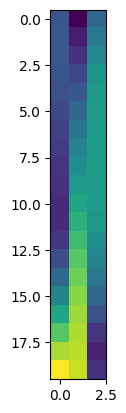

In [37]:
# Создаем colormap
cmap = plt.cm.get_cmap('viridis')

# Получаем палитру размера k
palette = cmap(np.linspace(0, 1, k))
palette = np.delete(palette, 3, axis=1)

plt.imshow(palette)
plt.show()

In [38]:
centers2.shape

(20, 384)

In [39]:
hr_feats_list_flat[0].shape

(256, 256, 384)

In [40]:
all_segmented_feats = []
for hr_feats in hr_feats_list_flat:
    segmented_feats = kmeans_predict(kmeans2, hr_feats, palette=palette)
    all_segmented_feats.append(segmented_feats)

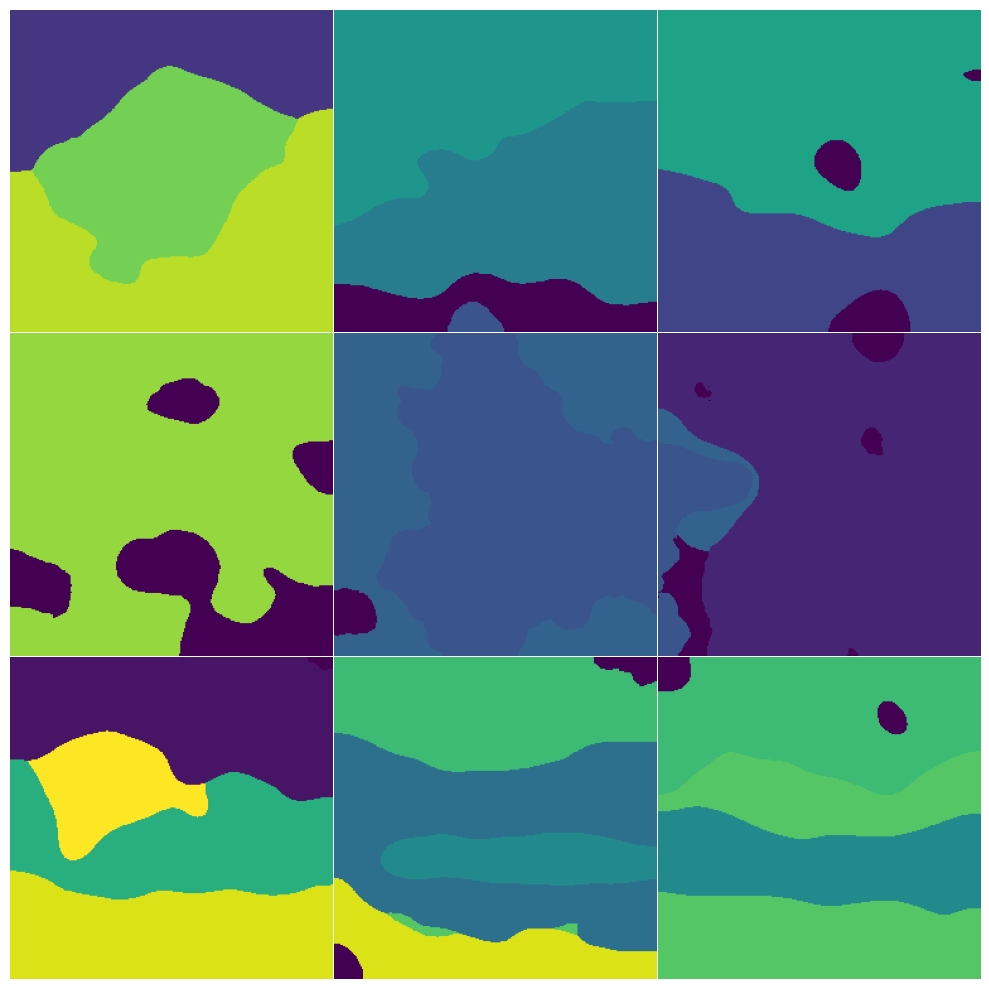

In [41]:
display_image_grid(all_segmented_feats, patches_mat_shape)

# Merge and blend patches

## series 1

In [35]:
def linear_blend_masks(masks, patch_size, overlap):
    num_patches_h, num_patches_w = masks.shape[0], masks.shape[1]
    full_height = num_patches_h * patch_size - (num_patches_h - 1) * overlap
    full_width = num_patches_w * patch_size - (num_patches_w - 1) * overlap
    full_mask = np.zeros((full_height, full_width, masks.shape[-1]), dtype=np.float32)
    weight_mask = np.zeros_like(full_mask)

    for i in range(num_patches_h):
        for j in range(num_patches_w):
            y_start = i * (patch_size - overlap)
            x_start = j * (patch_size - overlap)
            y_end = y_start + patch_size
            x_end = x_start + patch_size

            patch_mask = masks[i, j]
            if i > 0:
                patch_mask[:overlap, :] *= np.linspace(0, 1, overlap*3).reshape(-1, 1, 3)
            if j > 0:
                patch_mask[:, :overlap] *= np.linspace(0, 1, overlap*3).reshape(-1,3)
            if i < num_patches_h - 1:
                patch_mask[-overlap:, :] *= np.linspace(1, 0, overlap*3).reshape(-1, 1, 3)
            if j < num_patches_w - 1:
                patch_mask[:, -overlap:] *= np.linspace(1, 0, overlap*3).reshape(-1,3)

            print(
                f'{full_mask[y_start:y_end, x_start:x_end].shape=} {patch_mask.shape=}')
            full_mask[y_start:y_end, x_start:x_end] += patch_mask
            weight_mask[y_start:y_end, x_start:x_end] += 1

    full_mask /= np.maximum(weight_mask, 1)
    return full_mask


def gaussian_blend_masks(masks, patch_size, overlap):
    num_patches_h, num_patches_w = masks.shape[0], masks.shape[1]
    full_height = num_patches_h * patch_size - (num_patches_h - 1) * overlap
    full_width = num_patches_w * patch_size - (num_patches_w - 1) * overlap
    full_mask = np.zeros((full_height, full_width), dtype=np.float32)
    weight_mask = np.zeros_like(full_mask)

    gaussian_weights = np.outer(cv2.getGaussianKernel(overlap * 2 + 1, 0.3 * ((overlap * 2 + 1) - 1) + 0.8),
                                cv2.getGaussianKernel(overlap * 2 + 1, 0.3 * ((overlap * 2 + 1) - 1) + 0.8))

    for i in range(num_patches_h):
        for j in range(num_patches_w):
            y_start = i * (patch_size - overlap)
            x_start = j * (patch_size - overlap)
            y_end = y_start + patch_size
            x_end = x_start + patch_size

            patch_mask = masks[i, j]
            if i > 0:
                patch_mask[:overlap, :] *= gaussian_weights[overlap:,
                                                            overlap:].reshape(-1, 1)
            if j > 0:
                patch_mask[:, :overlap] *= gaussian_weights[overlap:, overlap:]
            if i < num_patches_h - 1:
                patch_mask[-overlap:, :] *= gaussian_weights[:overlap,
                                                             overlap:].reshape(-1, 1)
            if j < num_patches_w - 1:
                patch_mask[:, -overlap:] *= gaussian_weights[overlap:, :overlap]

            full_mask[y_start:y_end, x_start:x_end] += patch_mask
            weight_mask[y_start:y_end, x_start:x_end] += 1

    full_mask /= np.maximum(weight_mask, 1)
    return full_mask

## series 2

In [36]:
def blend_patches(patches, patch_size, overlap):
    """
    Blend a matrix of overlapping patches into one large image.

    Parameters:
    patches (numpy array): A 4D array of shape (num_patches_y, num_patches_x, patch_size[0], patch_size[1])
    patch_size (tuple): The size of each patch (height, width)
    overlap (int): The number of overlapping pixels between patches

    Returns:
    numpy array: The blended large image
    """
    num_patches_y, num_patches_x = patches.shape[:2]
    patch_height, patch_width = patch_size

    # Calculate the size of the final image
    final_height = num_patches_y * patch_height - (num_patches_y - 1) * overlap
    final_width = num_patches_x * patch_width - (num_patches_x - 1) * overlap

    # Initialize the final image
    final_image = np.zeros(
        (final_height, final_width, patches.shape[2]), dtype=patches.dtype)

    # Initialize the weight mask
    weight_mask = np.zeros((patch_height, patch_width), dtype=np.float32)
    weight_mask[:overlap, :] = np.linspace(0, 1, overlap)
    weight_mask[-overlap:, :] = np.linspace(1, 0, overlap)
    weight_mask[:, :overlap] = np.linspace(0, 1, overlap)[np.newaxis, :]
    weight_mask[:, -overlap:] = np.linspace(1, 0, overlap)[np.newaxis, :]
    weight_mask[overlap:-overlap, overlap:-overlap] = 1

    # Blend the patches into the final image
    for i in range(num_patches_y):
        for j in range(num_patches_x):
            patch = patches[i, j]
            y_start = i * (patch_height - overlap)
            y_end = y_start + patch_height
            x_start = j * (patch_width - overlap)
            x_end = x_start + patch_width

            # Apply the weight mask to the patch
            weighted_patch = patch * weight_mask[..., np.newaxis]

            # Blend the patch into the final image
            final_image[y_start:y_end, x_start:x_end] += weighted_patch

    return final_image

## Series 3

In [37]:
from scipy.interpolate import interp2d


def blend_patches_interpolate(patches, patch_size, overlap):
    """
    Blend a matrix of overlapping patches into one large image using interpolation.

    Parameters:
    patches (numpy array): A 4D array of shape (num_patches_y, num_patches_x, patch_size[0], patch_size[1], channels)
    patch_size (tuple): The size of each patch (height, width)
    overlap (int): The number of overlapping pixels between patches

    Returns:
    numpy array: The blended large image
    """
    num_patches_y, num_patches_x = patches.shape[:2]
    patch_height, patch_width = patch_size
    channels = patches.shape[4]

    # Calculate the size of the final image
    final_height = num_patches_y * patch_height - (num_patches_y - 1) * overlap
    final_width = num_patches_x * patch_width - (num_patches_x - 1) * overlap

    # Initialize the final image
    final_image = np.zeros(
        (final_height, final_width, channels), dtype=patches.dtype)

    # Create a grid for interpolation
    x = np.linspace(0, patch_width - 1, patch_width)
    y = np.linspace(0, patch_height - 1, patch_height)
    xx, yy = np.meshgrid(x, y)

    # Blend the patches into the final image using interpolation
    for i in range(num_patches_y):
        for j in range(num_patches_x):
            patch = patches[i, j]
            y_start = i * (patch_height - overlap)
            y_end = y_start + patch_height
            x_start = j * (patch_width - overlap)
            x_end = x_start + patch_width

            # Create a weight mask for interpolation
            weight_mask = np.ones((patch_height, patch_width))
            if i > 0:
                weight_mask[:overlap,
                            :] *= np.linspace(0, 1, overlap)[:, np.newaxis]
            if i < num_patches_y - 1:
                weight_mask[-overlap:,
                            :] *= np.linspace(1, 0, overlap)[:, np.newaxis]
            if j > 0:
                weight_mask[:,
                            :overlap] *= np.linspace(0, 1, overlap)[np.newaxis, :]
            if j < num_patches_x - 1:
                weight_mask[:, -
                            overlap:] *= np.linspace(1, 0, overlap)[np.newaxis, :]

            # Apply the weight mask to the patch
            weighted_patch = patch * weight_mask[..., np.newaxis]

            # Interpolate the patch
            for c in range(channels):
                interpolator = interp2d(
                    xx, yy, weighted_patch[..., c], kind='linear')
                final_image[y_start:y_end, x_start:x_end,
                            c] += interpolator(x, y)

    return final_image

## Series 4

In [75]:
import numpy as np
# from skimage.util import view_as_windows


def blend_patches_g(patches, patch_size, overlap, blend_func=np.mean):
  """Blends overlapping patches into a single image.

  Args:
    patches: A numpy array of shape (num_patches, patch_size, patch_size, channels).
    patch_size: The size of each patch.
    overlap: The overlap between adjacent patches.
    blend_func: The blending function to use (default: np.mean).

  Returns:
    The blended image as a numpy array.
  """

  cols, rows, _, _, channels = patches.shape
  patch_step = patch_size - overlap

  # Calculate output image dimensions
  output_size = (rows * patch_step + overlap)

  # Create empty output image
  output_image = np.zeros(
      (output_size, output_size, channels), dtype=patches.dtype)

  # Iterate through patches
  for i in range(cols):
    for j in range(rows):
      patch = patches[i, j]
      start_x = i * patch_step
      end_x = start_x + patch_size
      start_y = j * patch_step
      end_y = start_y + patch_size

      # Calculate overlap region
      overlap_x = min(end_x, output_size) - max(start_x, 0)
      overlap_y = min(end_y, output_size) - max(start_y, 0)

      # Apply blending function
      output_image[start_x:end_x, start_y:end_y] = blend_func(
          (output_image[start_x:end_x, start_y:end_y],
           patch[:overlap_x, :overlap_y]),
          axis=0
      )

  return output_image

In [72]:
from scipy.interpolate import RectBivariateSpline


def smooth_blend_patches_intp(patches, patch_size, overlap):
  """Smoothly blends overlapping patches into a single image using 2D interpolation.

  Args:
    patches: A numpy array of shape (num_patches, patch_size, patch_size, channels).
    patch_size: The size of each patch.
    overlap: The overlap between adjacent patches.

  Returns:
    The blended image as a numpy array.
  """

  # num_patches, _, _, channels = patches.shape
  cols, rows, _, _, channels = patches.shape
  num_patches = cols * rows
  patch_step = patch_size - overlap

  # Calculate output image dimensions
  output_size = (num_patches * patch_step + overlap)

  # Create empty output image
  output_image = np.zeros(
      (output_size, output_size, channels), dtype=patches.dtype)

  # Iterate through patches
  for i in range(cols):
    for j in range(rows):
      patch = patches[i, j]
      start_x = i * patch_step
      end_x = start_x + patch_size
      start_y = j * patch_step
      end_y = start_y + patch_size

      # Calculate overlap region
      overlap_x = min(end_x, output_size) - max(start_x, 0)
      overlap_y = min(end_y, output_size) - max(start_y, 0)

      # Create interpolation function
      interp_func = RectBivariateSpline(
          np.arange(patch_size), np.arange(patch_size), patch)

      # Generate coordinates for interpolation
      x = np.arange(start_x, min(end_x, output_size))
      y = np.arange(start_y, min(end_y, output_size))
      X, Y = np.meshgrid(x, y)

      # Interpolate patch values onto output image
      output_image[start_x:end_x, start_y:end_y] += interp_func(X, Y)

  return output_image

## Blend

In [76]:
print(f'{hr_feats_mat.shape=}')
# m = linear_blend_masks(hr_feats_mat, 256, output_overlap)

m = blend_patches_g(hr_feats_mat,  256, output_overlap)
# m = smooth_blend_patches_intp(hr_feats_mat, 256, output_overlap)

hr_feats_mat.shape=(5, 7, 256, 256, 3)


In [40]:
m.shape

(1024, 1408, 3)

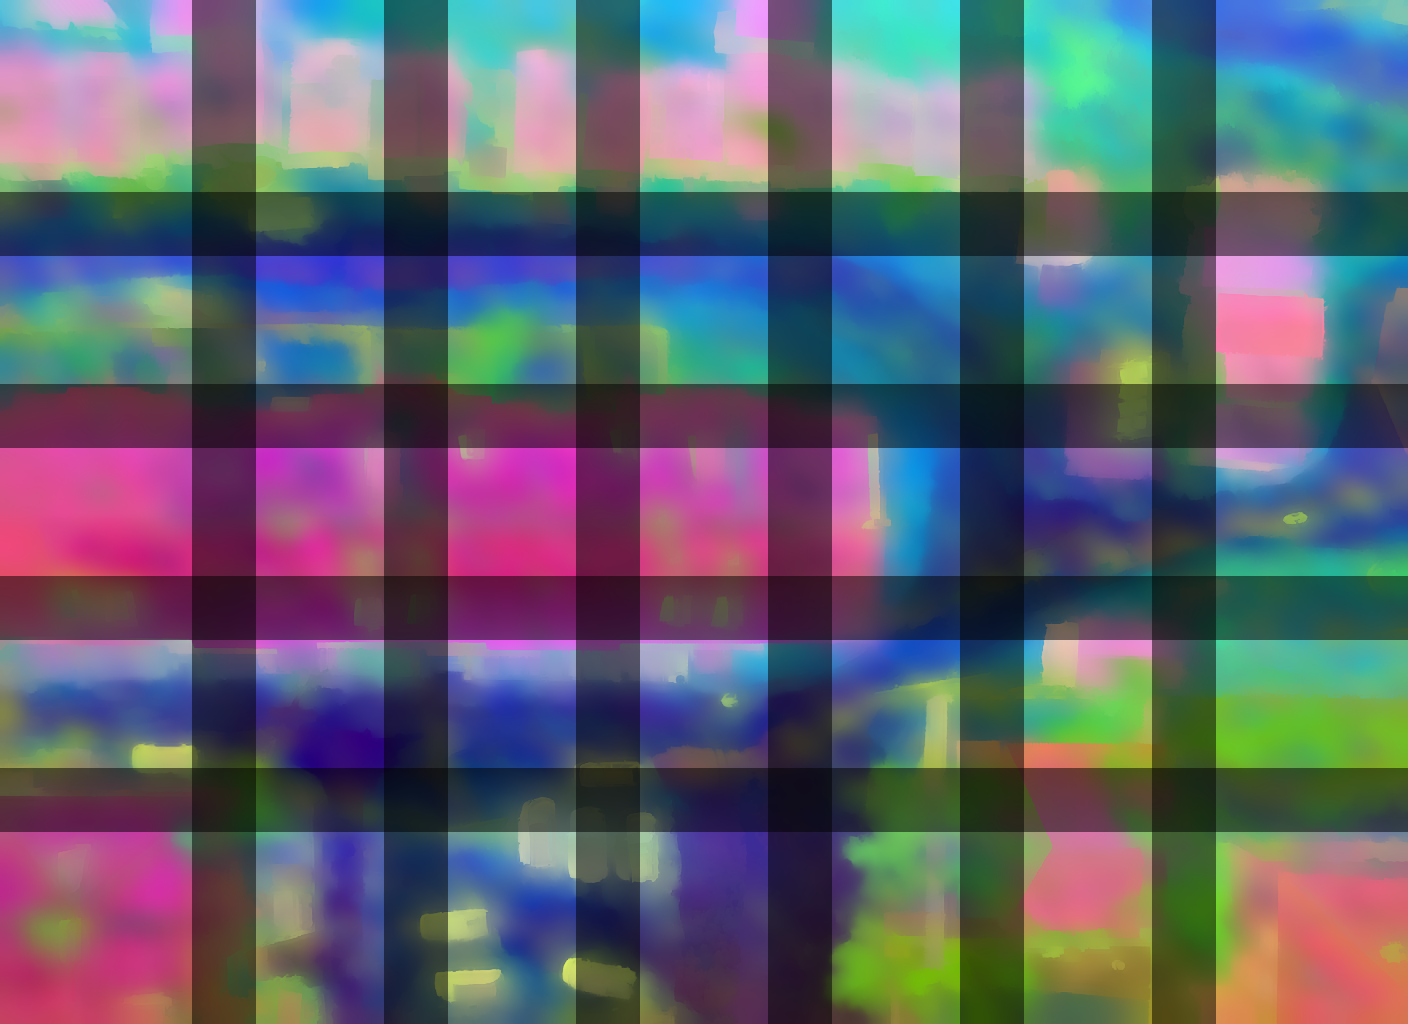

In [41]:
import matplotlib.pyplot as plt


rim = Image.fromarray((m*255).astype(np.uint8))

# fig, ax = plt.subplots(figsize=(10, 10))  
# ax.imshow(m)
# ax.set_axis_off()
# # plt.colorbar()
# plt.show()
rim